In [355]:
#1. Load environment
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ARDL
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import breaks_cusumolsresid
from statsmodels.tsa.regime_switching.markov_switching import MarkovSwitching
from scipy.stats import zscore
from scipy.stats import chi2
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress


In [356]:
#2. Load the data

aer = pd.read_csv('/Users/sandimakhathini/data/aer_1940_2010_indicator.csv', sep=';')
ecta = pd.read_csv('/Users/sandimakhathini/data/ecta_1940_2010_indicator.csv', sep=';')
jpe = pd.read_csv('/Users/sandimakhathini/data/jpe_1940_2010_indicator.csv', sep=';')
qje = pd.read_csv('/Users/sandimakhathini/data/qje_1940_2010_indicator.csv', sep=';')
res = pd.read_csv('/Users/sandimakhathini/data/res_1940_2010_indicator.csv', sep=';')

df = [aer, ecta, jpe, qje, res]

ref_columns = jpe.columns


In [357]:
#  Check and fix headers
def check_and_fix_headers(df, df_label):
    if not ref_columns.equals(jpe.columns):
        print(f"Headers do not match for {df_label}. Here's a comparison:")
        print("Reference (df1) headers:", ref_columns)
        print(f"{df_label} headers:", jpe.columns)
        # Fixing the headers by renaming columns to match the reference if needed
        jpe.columns = ref_columns
        print(f"{df_label} headers have been updated to match the reference.")
    else:
        print(f"Headers match for {df_label}")

# 6. Check and fix headers for each DataFrame
check_and_fix_headers(aer, "aer")
check_and_fix_headers(ecta, "ecta")
check_and_fix_headers(jpe, "jpe")
check_and_fix_headers(qje, "qje")
check_and_fix_headers(res, "res")

Headers match for aer
Headers match for ecta
Headers match for jpe
Headers match for qje
Headers match for res


In [358]:
print("Head of aer:")
print(aer.head())

print("\nHead of ecta:")
print(ecta.head())

print("\nHead of jpe:")
print(jpe.head())

print("\nHead of qje:")
print(qje.head())

print("\nHead of res:")
print(res.head())

Head of aer:
                                             pdf_url  year journal equations  \
0  'https://myawsbucket-1231.s3.eu-west-3.amazona...  2010     AER       NaN   
1  'https://myawsbucket-1231.s3.eu-west-3.amazona...  2010     AER       NaN   
2  'https://myawsbucket-1231.s3.eu-west-3.amazona...  2010     AER       NaN   
3  'https://myawsbucket-1231.s3.eu-west-3.amazona...  2010     AER       1.0   
4  'https://myawsbucket-1231.s3.eu-west-3.amazona...  2010     AER       1.0   

         id  page  
0  27871262     0  
1  27871262     1  
2  27871262     2  
3  27871262     3  
4  27871262     4  

Head of ecta:
                                             pdf_url  year journal equations  \
0  'https://myawsbucket-1231.s3.eu-west-3.amazona...  1969    ECTA       1.0   
1  'https://myawsbucket-1231.s3.eu-west-3.amazona...  1969    ECTA       1.0   
2  'https://myawsbucket-1231.s3.eu-west-3.amazona...  1969    ECTA       1.0   
3  'https://myawsbucket-1231.s3.eu-west-3.amazona..

In [359]:
# Check column names for each dataset
print("Columns in AER:")
print(aer.columns)

print("\nColumns in ECTA:")
print(ecta.columns)

print("\nColumns in JPE:")
print(jpe.columns)

print("\nColumns in QJE:")
print(qje.columns)

print("\nColumns in RES:")
print(res.columns)

Columns in AER:
Index(['pdf_url', 'year', 'journal', 'equations', 'id', 'page'], dtype='object')

Columns in ECTA:
Index(['pdf_url', 'year', 'journal', 'equations', 'id', 'page'], dtype='object')

Columns in JPE:
Index(['pdf_url', 'year', 'journal', 'equations', 'id', 'page'], dtype='object')

Columns in QJE:
Index(['pdf_url', 'year', 'journal', 'equations', 'id', 'page'], dtype='object')

Columns in RES:
Index(['pdf_url', 'year', 'journal', 'equations', 'id', 'page'], dtype='object')


In [360]:

print("Unique values for 'equations' in AER:")
print(aer['equations'].unique())

print("\nUnique values for 'equations' in ECTA:")
print(ecta['equations'].unique())

print("\nUnique values for 'equations' in JPE:")
print(jpe['equations'].unique())

print("\nUnique values for 'equations' in QJE:")
print(qje['equations'].unique())

print("\nUnique values for 'equations' in RES:")
print(res['equations'].unique())


Unique values for 'equations' in AER:
[nan '1.0' '11.0' '1' '2' '21' '11' "'1" '\x1b' '0.0' '\\' '0']

Unique values for 'equations' in ECTA:
['1.0' nan '11.0' '1' '1\\' '11' '0']

Unique values for 'equations' in JPE:
['0' '1' '1.0' nan '11.0' '11' '1\\' 'q' '1end' '0.0']

Unique values for 'equations' in QJE:
['1' '#VALUE!']

Unique values for 'equations' in RES:
['e' nan 'ee' 'e\\' 'emd' 'eee' '0' '1']


In [361]:
pd.set_option('future.no_silent_downcasting', True)

In [362]:
replacement_map = {
    '0':0,
    '1':1,
    '1.0': 1,           # Replace with 1
    '11.0': 1,       
     '11': 1,       
    '1end': 1,        
    'q': 1,       
    '1\\': 1,
    '0.0':0,
    None: 0,        # Replace empty cells (None or NaN) with 0
    pd.NA: 0,       # Replace empty cells (pd.NA) with 0
    'Invalid': 0,   # Replace Invalid with 0
    'Missing': 0,    # Replace Missing with 0
    '#VALUE!':0,
    '\x1b': 1,
    '\\': 0,
    '2': 0,
    '21': 1,
    "'1": 1,
    'e': 1,
    'ee': 1, 
    'e\\':1,
    'emd': 0,
    'eee': 1
}




In [363]:
aer['equations'] = aer['equations'].replace(replacement_map)
ecta['equations'] = ecta['equations'].replace(replacement_map)
jpe['equations'] = jpe['equations'].replace(replacement_map)
qje['equations'] = qje['equations'].replace(replacement_map)
res['equations'] = res['equations'].replace(replacement_map)

In [364]:
# Print unique values for the "equations" column for each dataset

print("Unique values for 'equations' in AER:")
print(aer['equations'].unique())

print("\nUnique values for 'equations' in ECTA:")
print(ecta['equations'].unique())

print("\nUnique values for 'equations' in JPE:")
print(jpe['equations'].unique())

print("\nUnique values for 'equations' in QJE:")
print(qje['equations'].unique())

print("\nUnique values for 'equations' in RES:")
print(res['equations'].unique())

Unique values for 'equations' in AER:
[0 1]

Unique values for 'equations' in ECTA:
[1 0]

Unique values for 'equations' in JPE:
[0 1]

Unique values for 'equations' in QJE:
[1 0]

Unique values for 'equations' in RES:
[1 0]


In [365]:
# Ensure 'year' is an integer and 'equations' is a binary column (0 or 1) for each dataset
aer['year'] = aer['year'].astype(int)
aer['equations'] = aer['equations'].astype(int)

ecta['year'] = ecta['year'].astype(int)
ecta['equations'] = ecta['equations'].astype(int)

jpe['year'] = jpe['year'].astype(int)
jpe['equations'] = jpe['equations'].astype(int)

qje['year'] = qje['year'].astype(int)
qje['equations'] = qje['equations'].astype(int)

res['year'] = res['year'].astype(int)
res['equations'] = res['equations'].astype(int)


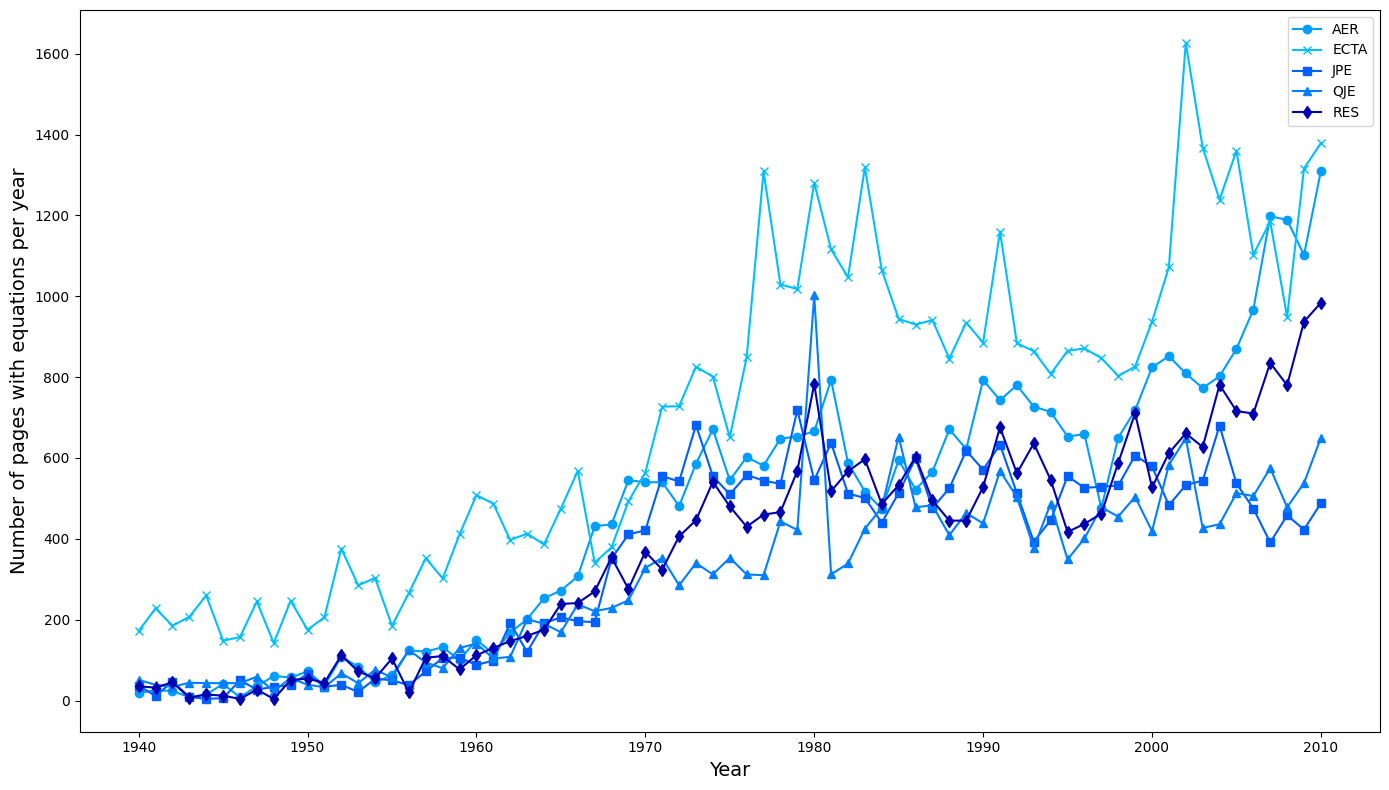

In [366]:
# Number of figures per year before normalisation
# Extract year and figures for each journal
aer_equations = aer.groupby('year')['equations'].sum()
ecta_equations = ecta.groupby('year')['equations'].sum()
jpe_equations = jpe.groupby('year')['equations'].sum()
qje_equations = qje.groupby('year')['equations'].sum()
res_equations = res.groupby('year')['equations'].sum()

# Combine all journals into a single dataframe
data = {
    'AER': aer_equations,
    'ECTA': ecta_equations,
    'JPE': jpe_equations,
    'QJE': qje_equations,
    'RES': res_equations
}

# Create a pivoted dataframe for plotting
pivoted = pd.DataFrame(data)

# Plot the data
plt.figure(figsize=(14, 8))

plt.plot(pivoted.index, pivoted['AER'], label='AER', marker='o', color='#009fff')
plt.plot(pivoted.index, pivoted['ECTA'], label='ECTA', marker='x', color='#00bfff')
plt.plot(pivoted.index, pivoted['JPE'], label='JPE', marker='s', color='#0060ff')
plt.plot(pivoted.index, pivoted['QJE'], label='QJE', marker='^', color='#0080ff')
plt.plot(pivoted.index, pivoted['RES'], label='RES', marker='d', color='#0000b3')

# Customize the graph
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of pages with equations per year', fontsize=14)
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [367]:
# Calculate trend
# Define a function to calculate trend slope
def calculate_trend(data):
    years = data.index.values
    equations = data.values
    slope, intercept, r_value, p_value, std_err = linregress(years, equations)
    return slope, p_value

# Calculate trends for each journal
aer_slope, aer_p_value = calculate_trend(aer_equations)
ecta_slope, ecta_p_value = calculate_trend(ecta_equations)
jpe_slope, jpe_p_value = calculate_trend(jpe_equations)
qje_slope, qje_p_value = calculate_trend(qje_equations)
res_slope, res_p_value = calculate_trend(res_equations)

# Print results
print(f"AER Trend: Slope={aer_slope:.2f}, p-value={aer_p_value:.2e}")
print(f"ECTA Trend: Slope={ecta_slope:.2f}, p-value={ecta_p_value:.2e}")
print(f"JPE Trend: Slope={jpe_slope:.2f}, p-value={jpe_p_value:.2e}")
print(f"QJE Trend: Slope={qje_slope:.2f}, p-value={qje_p_value:.2e}")
print(f"RES Trend: Slope={res_slope:.2f}, p-value={res_p_value:.2e}")

AER Trend: Slope=15.48, p-value=1.46e-34
ECTA Trend: Slope=17.03, p-value=6.61e-25
JPE Trend: Slope=9.41, p-value=2.78e-19
QJE Trend: Slope=8.80, p-value=8.52e-23
RES Trend: Slope=12.23, p-value=1.25e-33


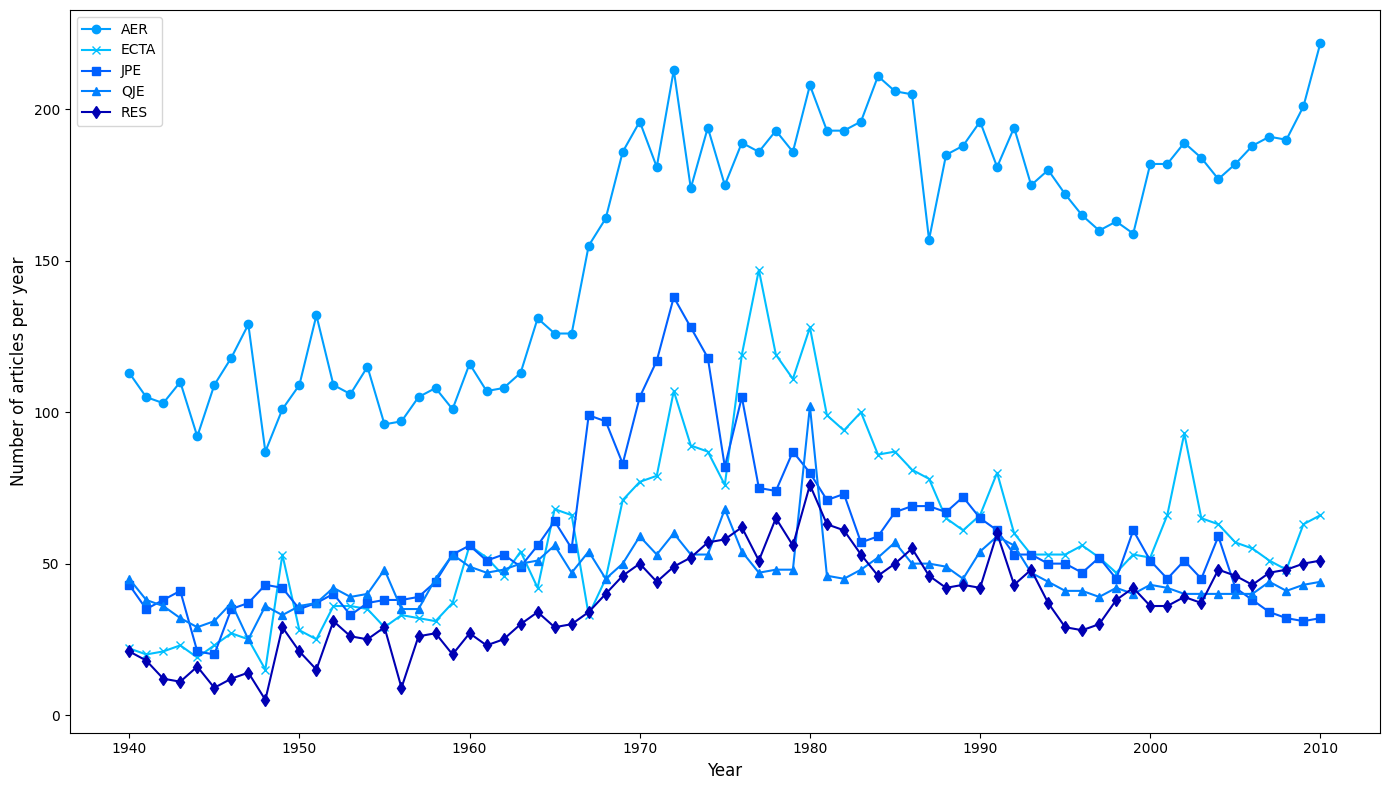

In [368]:
# Function to count articles by year
def count_articles_by_year(df):
    # Group by 'year' and count unique article IDs
    articles_per_year = df.groupby('year')['id'].nunique()
    return articles_per_year

# Count articles for each journal
aer_articles = count_articles_by_year(aer)
ecta_articles = count_articles_by_year(ecta)
jpe_articles = count_articles_by_year(jpe)
qje_articles = count_articles_by_year(qje)
res_articles = count_articles_by_year(res)

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(aer_articles.index, aer_articles.values, label='AER', marker='o', color='#009fff')
plt.plot(ecta_articles.index, ecta_articles.values, label='ECTA', marker='x', color='#00bfff')
plt.plot(jpe_articles.index, jpe_articles.values, label='JPE', marker='s', color='#0060ff')
plt.plot(qje_articles.index, qje_articles.values, label='QJE', marker='^', color='#0080ff')
plt.plot(res_articles.index, res_articles.values, label='RES', marker='d', color='#0000b3')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of articles per year', fontsize=12)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


In [369]:
# Function to create a decade column
def create_decade_column(df):
    # Create a new column for the decade (floor to the nearest ten)
    df['decade'] = (df['year'] // 10) * 10
    return df

# Apply the decade column function to all datasets
aer = create_decade_column(aer)
ecta = create_decade_column(ecta)
jpe = create_decade_column(jpe)
qje = create_decade_column(qje)
res = create_decade_column(res)

# Function to count articles per decade
def count_articles_per_decade(df):
    return df.groupby('decade')['id'].nunique()  # Count unique article IDs

# Count articles for each journal by decade
aer_decades = count_articles_per_decade(aer)
ecta_decades = count_articles_per_decade(ecta)
jpe_decades = count_articles_per_decade(jpe)
qje_decades = count_articles_per_decade(qje)
res_decades = count_articles_per_decade(res)

# Create a DataFrame to consolidate results
decade_table = pd.DataFrame({
    'AER': aer_decades,
    'ECTA': ecta_decades,
    'JPE': jpe_decades,
    'QJE': qje_decades,
    'RES': res_decades
})

# Fill NaN values with 0 (if there are any decades with no articles)
decade_table.fillna(0, inplace=True)

# Convert to integer type
decade_table = decade_table.astype(int)

# Print the table
print(decade_table)


         AER  ECTA   JPE  QJE  RES
decade                            
1940    1067   248   355  342  147
1950    1078   322   394  410  229
1960    1332   533   663  497  318
1970    1887  1011  1029  543  544
1980    1942   879   684  544  535
1990    1745   573   537  463  397
2000    1866   613   428  413  430
2010     222    66    32   44   51


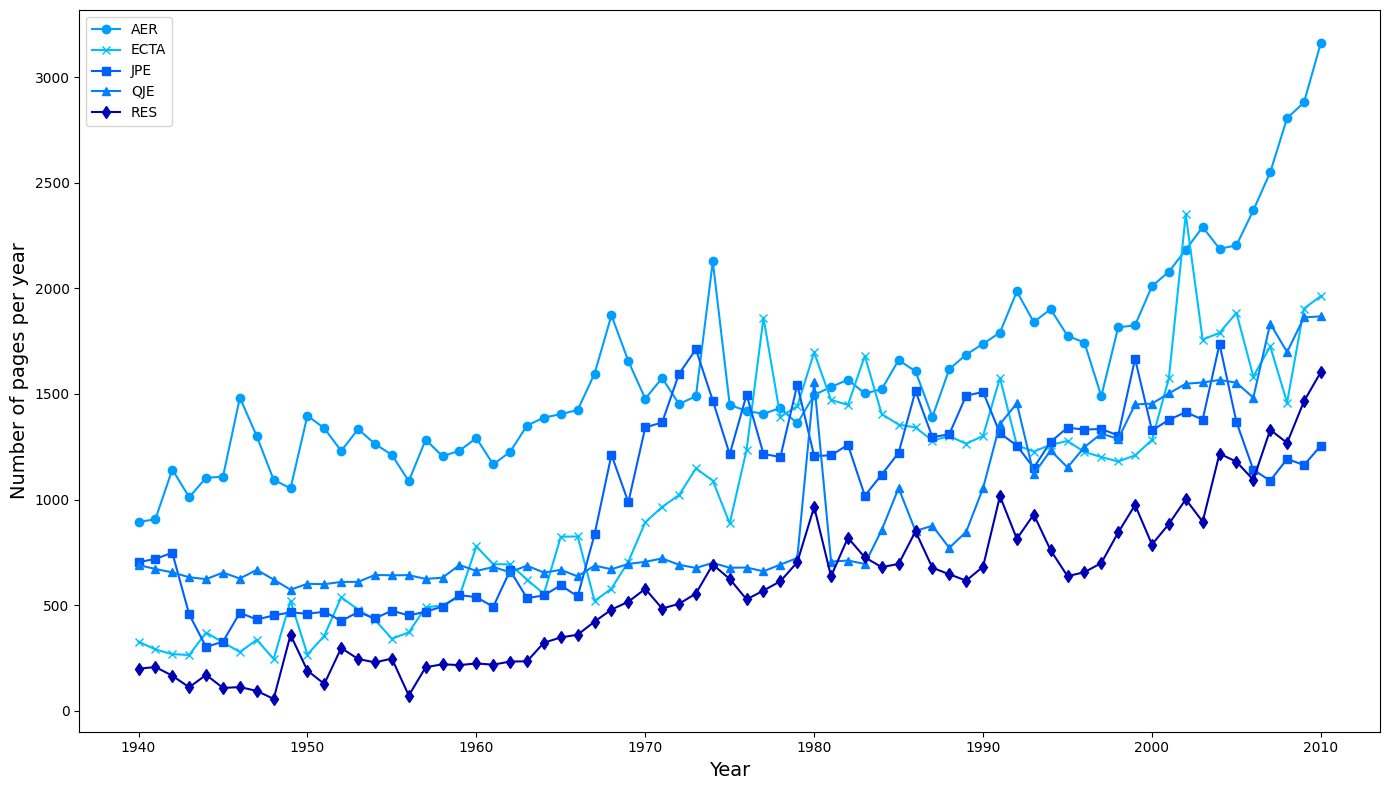

In [370]:
# Function to calculate total pages per year for each journal
def count_pages_per_year(df):
    return df.groupby('year')['id'].count()  # Sum the number of pages

# Calculate total pages per year for each journal
aer_pages_per_year = count_pages_per_year(aer)
ecta_pages_per_year = count_pages_per_year(ecta)
jpe_pages_per_year = count_pages_per_year(jpe)
qje_pages_per_year = count_pages_per_year(qje)
res_pages_per_year = count_pages_per_year(res)

# Combine results into a DataFrame
pages_per_year = pd.DataFrame({
    'AER': aer_pages_per_year,
    'ECTA': ecta_pages_per_year,
    'JPE': jpe_pages_per_year,
    'QJE': qje_pages_per_year,
    'RES': res_pages_per_year
})

# Fill NaN values with 0 (if there are any years with no pages)
pages_per_year.fillna(0, inplace=True)

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(pages_per_year.index, pages_per_year['AER'], marker='o', label='AER', color='#009fff')
plt.plot(pages_per_year.index, pages_per_year['ECTA'], marker='x', label='ECTA', color='#00bfff')
plt.plot(pages_per_year.index, pages_per_year['JPE'], marker='s', label='JPE', color='#0060ff')
plt.plot(pages_per_year.index, pages_per_year['QJE'], marker='^', label='QJE', color='#0080ff')
plt.plot(pages_per_year.index, pages_per_year['RES'], marker='d', label='RES',  color='#0000b3')


# Adding titles and labels
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of pages per year', fontsize=14)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

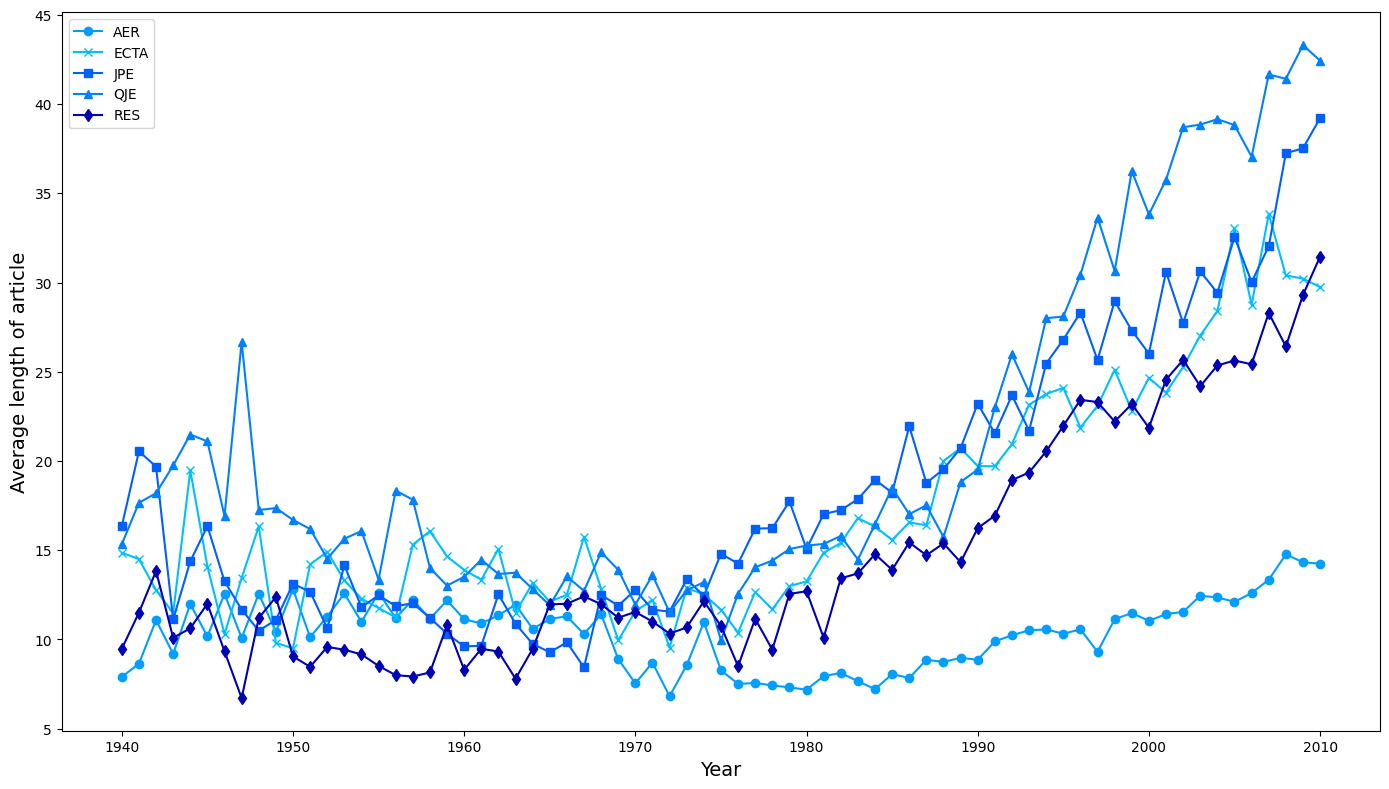

In [371]:
# Function to calculate total articles and pages per year for each journal
def count_articles_and_pages(df):
    total_articles = df.groupby('year')['id'].nunique()  # Count unique article IDs
    total_pages = df.groupby('year')['id'].count()  # Count the number of pages
    return total_articles, total_pages

# Calculate total articles and pages for each journal
aer_articles, aer_pages = count_articles_and_pages(aer)
ecta_articles, ecta_pages = count_articles_and_pages(ecta)
jpe_articles, jpe_pages = count_articles_and_pages(jpe)
qje_articles, qje_pages = count_articles_and_pages(qje)
res_articles, res_pages = count_articles_and_pages(res)

# Calculate average length of articles for each year
average_length_aer = aer_pages / aer_articles
average_length_ecta = ecta_pages / ecta_articles
average_length_jpe = jpe_pages / jpe_articles
average_length_qje = qje_pages / qje_articles
average_length_res = res_pages / res_articles

# Combine results into a DataFrame
average_length_per_year = pd.DataFrame({
    'AER': average_length_aer,
    'ECTA': average_length_ecta,
    'JPE': average_length_jpe,
    'QJE': average_length_qje,
    'RES': average_length_res
})

# Fill NaN values with 0 (if there are any years with no articles)
average_length_per_year.fillna(0, inplace=True)

# Plotting the average article lengths
plt.figure(figsize=(14, 8))
plt.plot(average_length_per_year.index, average_length_per_year['AER'], marker='o', label='AER', color='#009fff')
plt.plot(average_length_per_year.index, average_length_per_year['ECTA'], marker='x', label='ECTA', color='#00bfff')
plt.plot(average_length_per_year.index, average_length_per_year['JPE'], marker='s', label='JPE', color='#0060ff')
plt.plot(average_length_per_year.index, average_length_per_year['QJE'], marker='^', label='QJE', color='#0080ff')
plt.plot(average_length_per_year.index, average_length_per_year['RES'], marker='d', label='RES', color='#0000b3')

# Adding titles and labels
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average length of article', fontsize=14)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()



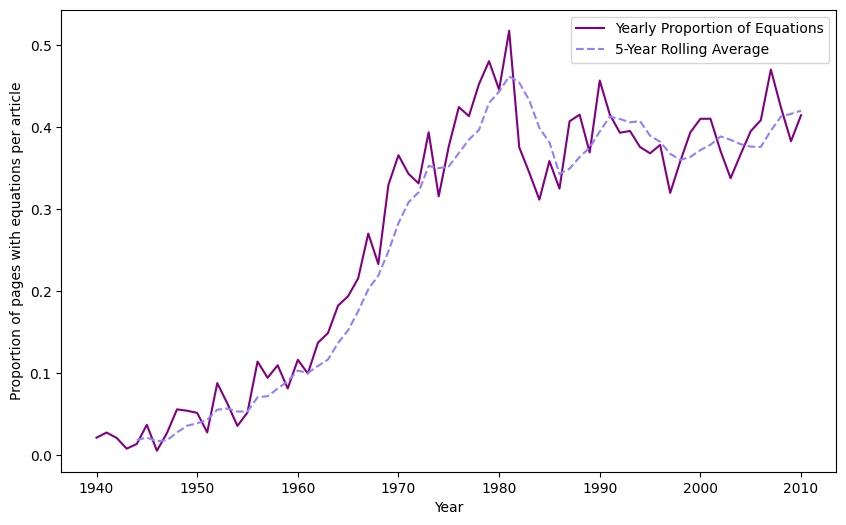

In [372]:
# Yearly proportion of articles containing equations
# AER
# Assuming 'year' is the time index and 'equations' is the binary variable (0 or 1)
aer_yearly = aer.groupby('year')['equations'].mean()

# Rolling average to smooth the trend
rolling_avg = aer_yearly.rolling(window=5).mean()

# Plot the yearly proportion and the rolling average
plt.figure(figsize=(10, 6))
plt.plot(aer_yearly, label='Yearly Proportion of Equations', color='purple')
plt.plot(rolling_avg, label='5-Year Rolling Average', linestyle='--', color='#9080ff')
plt.xlabel('Year')
plt.ylabel('Proportion of pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()


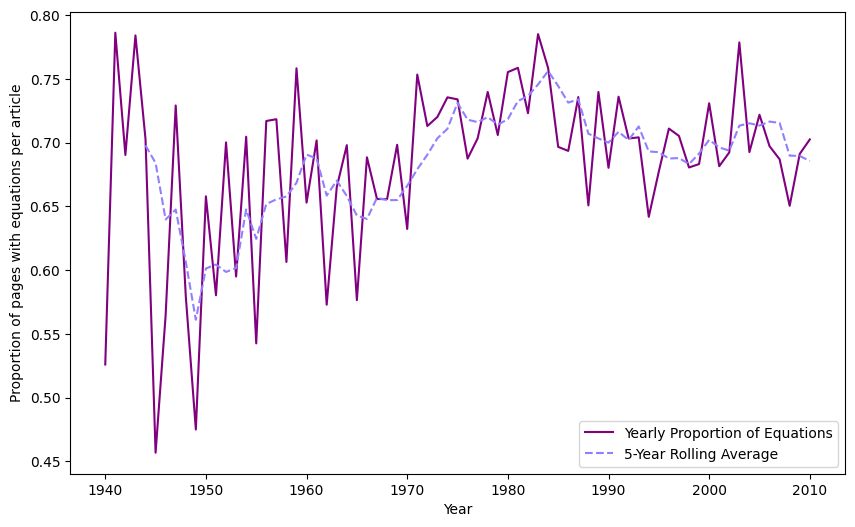

In [373]:
# Yearly proportion of articles containing equations
# ECTA
# Assuming 'year' is the time index and 'equations' is the binary variable (0 or 1)
ecta_yearly = ecta.groupby('year')['equations'].mean()

# Rolling average to smooth the trend
rolling_avg1 = ecta_yearly.rolling(window=5).mean()

# Plot the yearly proportion and the rolling average
plt.figure(figsize=(10, 6))
plt.plot(ecta_yearly, label='Yearly Proportion of Equations', color='purple')
plt.plot(rolling_avg1, label='5-Year Rolling Average', linestyle='--', color='#9080ff')
plt.xlabel('Year')
plt.ylabel('Proportion of pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()

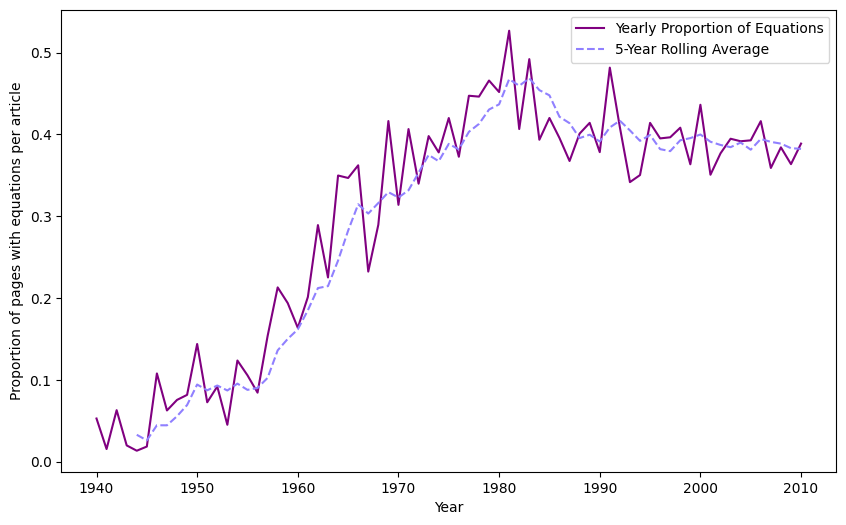

In [374]:
# Yearly proportion of articles containing equations
# JPE
# Assuming 'year' is the time index and 'equations' is the binary variable (0 or 1)
jpe_yearly = jpe.groupby('year')['equations'].mean()

# Rolling average to smooth the trend
rolling_avg2 = jpe_yearly.rolling(window=5).mean()

# Plot the yearly proportion and the rolling average
plt.figure(figsize=(10, 6))
plt.plot(jpe_yearly, label='Yearly Proportion of Equations', color='purple')
plt.plot(rolling_avg2, label='5-Year Rolling Average', linestyle='--', color='#9080ff')
plt.xlabel('Year')
plt.ylabel('Proportion of pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()

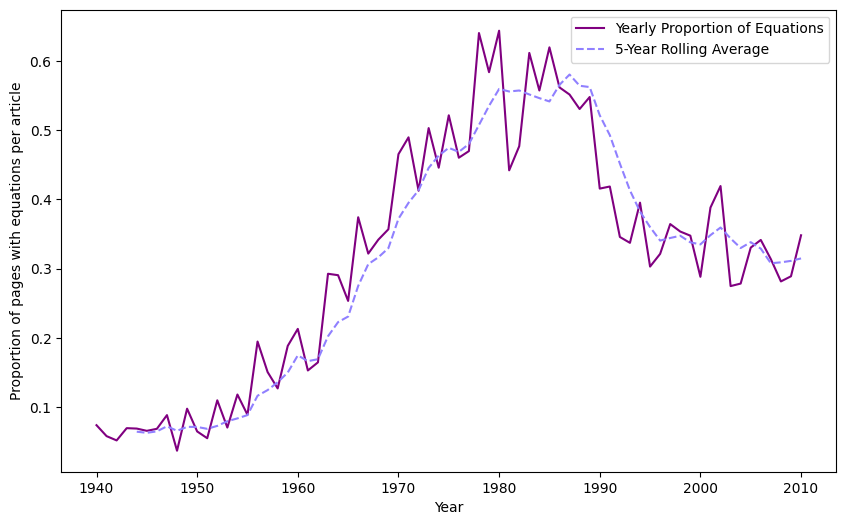

In [375]:
# Yearly proportion of articles containing equations
# QJE
# Assuming 'year' is the time index and 'equations' is the binary variable (0 or 1)
qje_yearly = qje.groupby('year')['equations'].mean()

# Rolling average to smooth the trend
rolling_avg3 = qje_yearly.rolling(window=5).mean()

# Plot the yearly proportion and the rolling average
plt.figure(figsize=(10, 6))
plt.plot(qje_yearly, label='Yearly Proportion of Equations', color='purple')
plt.plot(rolling_avg3, label='5-Year Rolling Average', linestyle='--', color='#9080ff')
plt.xlabel('Year')
plt.ylabel('Proportion of pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()

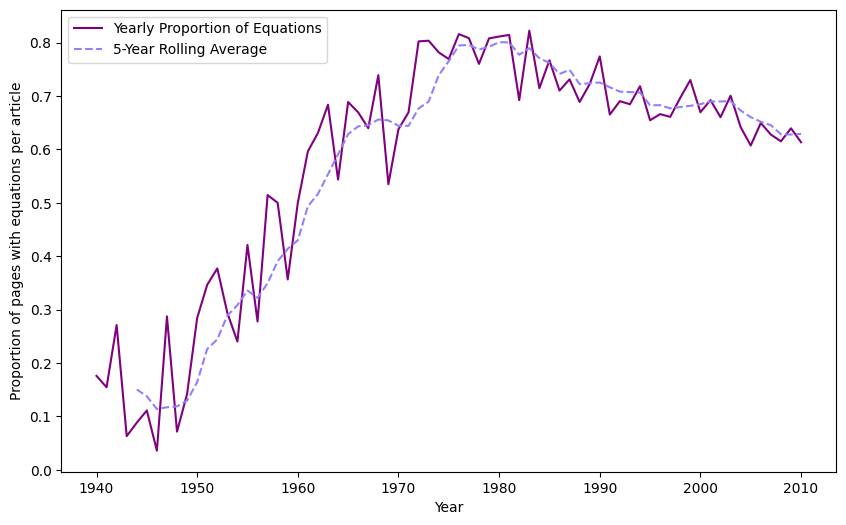

In [376]:
# Yearly proportion of articles containing equations
# RES
# Assuming 'year' is the time index and 'equations' is the binary variable (0 or 1)
res_yearly = res.groupby('year')['equations'].mean()

# Rolling average to smooth the trend
rolling_avg4 = res_yearly.rolling(window=5).mean()

# Plot the yearly proportion and the rolling average
plt.figure(figsize=(10, 6))
plt.plot(res_yearly, label='Yearly Proportion of Equations', color='purple')
plt.plot(rolling_avg4, label='5-Year Rolling Average', linestyle='--', color='#9080ff')
plt.xlabel('Year')
plt.ylabel('Proportion of pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()

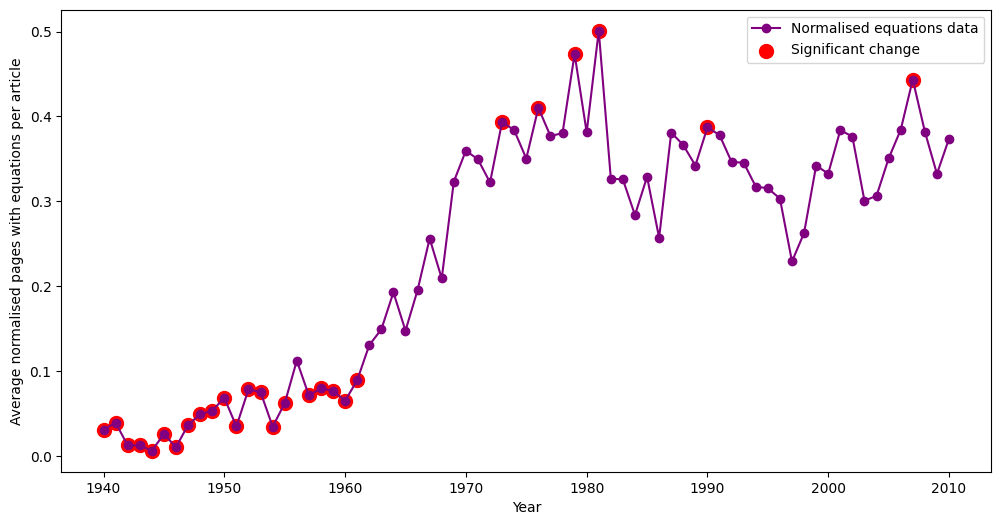

In [377]:
# AER
# Average Proportion of Pages with Equations per Article Over the Years
# Step 1: Calculate pages with equations and total pages for each article
article_data = aer.groupby('id').agg(
    total_pages=('page', 'size'),           
    pages_with_equations=('equations', 'sum')
)

# Step 2: Calculate a normalized score for each article by dividing pages with equations by total pages
article_data['normalized_equation_count'] = article_data['pages_with_equations'] / article_data['total_pages']

# Step 3: Merge back to add the year information to each article
article_data = article_data.merge(aer[['id', 'year']].drop_duplicates(), on='id')

# Step 4: Calculate the yearly average normalized equation count, weighted by article length
aer_yearly = article_data.groupby('year').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)

# Step 5: Calculate Z-scores and identify significant changes
threshold = 1
aer_yearly['z_score'] = zscore(aer_yearly['avg_normalized_equations'])
significant_years = aer_yearly[aer_yearly['z_score'].abs() > threshold]

# Step 6: Plotting
plt.figure(figsize=(12, 6))
plt.plot(aer_yearly.index, aer_yearly['avg_normalized_equations'], marker='o', color='purple', label='Normalised equations data')
plt.scatter(significant_years.index, significant_years['avg_normalized_equations'], color='red', label='Significant change', s=100)

#plt.title('Average Normalized Equations per Article Over the Years')
plt.xlabel('Year')
plt.ylabel('Average normalised pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()



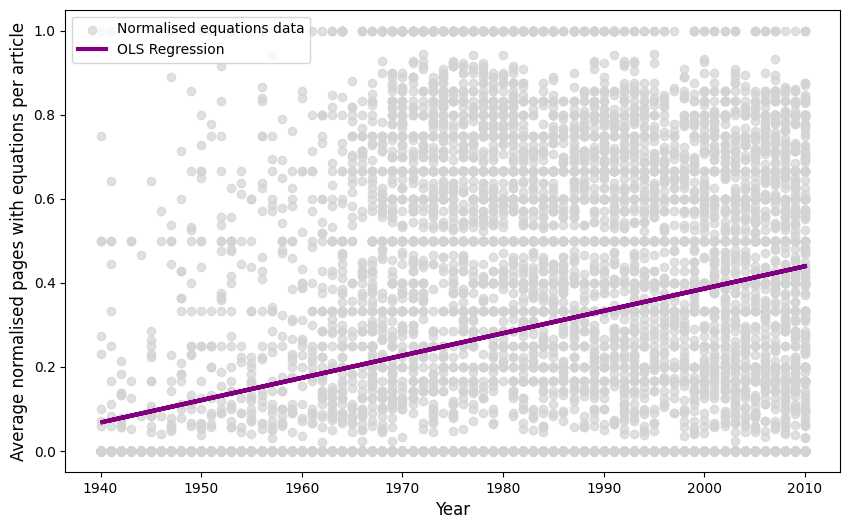

Intercept: 0.06722583163792897
Slope: 0.005314994665504668


In [378]:
# Independent and dependent variables
article_data['year_adj'] = article_data['year'] - 1940
X = article_data['year_adj'].values.reshape(-1, 1)  # Adjusted year as a feature
y = article_data['normalized_equation_count']

# Linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 3: Generate predictions for plotting
predicted_values = model.predict(X)

# Step 4: Plot the actual data points and regression line on the same graph
plt.figure(figsize=(10, 6))  

# Actual data (normalised)
plt.scatter(article_data['year'], y, color='lightgrey', alpha=0.7, label='Normalised equations data')

# Line plot for regression line
plt.plot(article_data['year'], predicted_values, color='purple', linewidth=3, label='OLS Regression')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average normalised pages with equations per article', fontsize=12)
plt.legend(fontsize=10)  
plt.grid(False)  
plt.show()

# Coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")




In [379]:
# Add a constant term (intercept) for statsmodels
X_with_constant = sm.add_constant(article_data['year_adj'])

# Fit the OLS regression model
ols_model = sm.OLS(article_data['normalized_equation_count'], X_with_constant).fit()

# Print the summary statistics
print(ols_model.summary())

# Actual values (y) and predicted values (y_hat)
y_actual = article_data['normalized_equation_count']
y_predicted = ols_model.predict(X_with_constant)  # Predicted values from the OLS model

# Calculate MSE
mse = mean_squared_error(y_actual, y_predicted)

print(f"Mean Squared Error (MSE): {mse}")


                                OLS Regression Results                               
Dep. Variable:     normalized_equation_count   R-squared:                       0.107
Model:                                   OLS   Adj. R-squared:                  0.107
Method:                        Least Squares   F-statistic:                     1337.
Date:                       Thu, 05 Dec 2024   Prob (F-statistic):          1.41e-276
Time:                               13:57:07   Log-Likelihood:                -2335.9
No. Observations:                      11139   AIC:                             4676.
Df Residuals:                          11137   BIC:                             4690.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [380]:
# Average proportion of pages with equations per article z-scores
# Step 1: Create a decade column if it’s not already in your data
article_data['decade'] = (article_data['year'] // 10) * 10

# Step 2: Calculate the average normalized equation count per decade
decade_data = article_data.groupby('decade').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)

# Step 3: Calculate the z-scores for the average normalized equation count per decade
decade_data['z_score'] = zscore(decade_data['avg_normalized_equations'])

# Step 4: Display the table with decade, avg_normalized_equations, and z_score
print(decade_data)

        avg_normalized_equations   z_score
decade                                    
1940                    0.027220 -1.716423
1950                    0.067748 -1.415632
1960                    0.188003 -0.523107
1970                    0.379198  0.895917
1980                    0.347548  0.661013
1990                    0.324953  0.493322
2000                    0.359605  0.750506
2010                    0.373604  0.854404


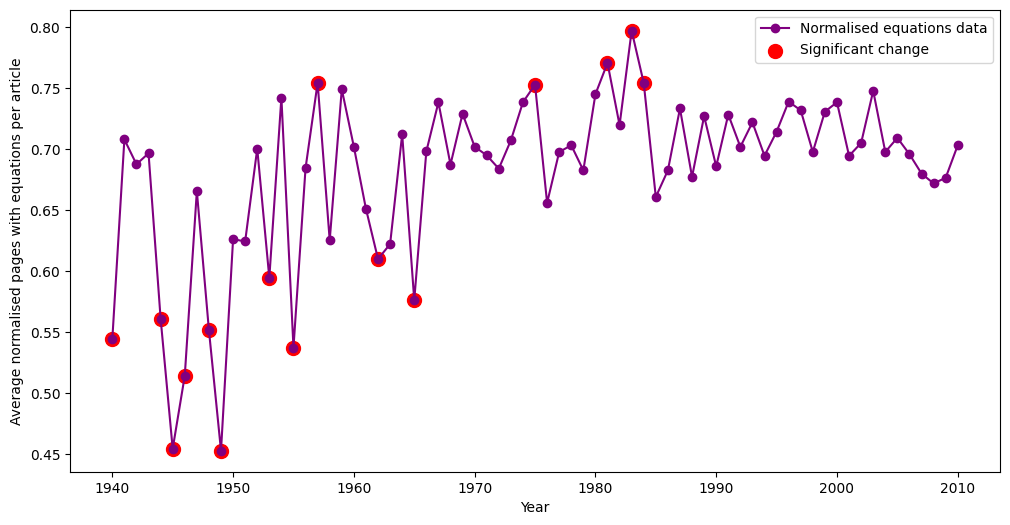

In [381]:
# ECTA
# Step 1: Calculate pages with equations and total pages for each article
ecta_article_data = ecta.groupby('id').agg(
    total_pages=('page', 'size'),
    pages_with_equations=('equations', 'sum')
)

# Step 2: Calculate a normalized score for each article
ecta_article_data['normalized_equation_count'] = ecta_article_data['pages_with_equations'] / ecta_article_data['total_pages']

# Step 3: Merge to add the year information
ecta_article_data = ecta_article_data.merge(ecta[['id', 'year']].drop_duplicates(), on='id')

# Step 4: Calculate the yearly average normalized equation count
ecta_yearly = ecta_article_data.groupby('year').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)

# Step 5: Calculate Z-scores and identify significant changes
ecta_yearly['z_score'] = zscore(ecta_yearly['avg_normalized_equations'])
significant_years_ecta = ecta_yearly[ecta_yearly['z_score'].abs() > threshold]

# Step 6: Plotting
plt.figure(figsize=(12, 6))
plt.plot(ecta_yearly.index, ecta_yearly['avg_normalized_equations'], marker='o', color='purple', label='Normalised equations data')
plt.scatter(significant_years_ecta.index, significant_years_ecta['avg_normalized_equations'], color='red', label='Significant change', s=100)
plt.xlabel('Year')
plt.ylabel('Average normalised pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()



In [382]:
# Average proportion of pages with equations per article z-scores
# Step 1: Create a decade column if it’s not already in your data
ecta_article_data['decade'] = (ecta_article_data['year'] // 10) * 10

# Step 2: Calculate the average normalized equation count per decade
decade_data = ecta_article_data.groupby('decade').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)

# Step 3: Calculate the z-scores for the average normalized equation count per decade
decade_data['z_score'] = zscore(decade_data['avg_normalized_equations'])

# Step 4: Display the table with decade, avg_normalized_equations, and z_score
print(decade_data)

        avg_normalized_equations   z_score
decade                                    
1940                    0.566661 -2.412881
1950                    0.668294 -0.285950
1960                    0.670030 -0.249633
1970                    0.699061  0.357926
1980                    0.730785  1.021827
1990                    0.714871  0.688793
2000                    0.702615  0.432306
2010                    0.703347  0.447611


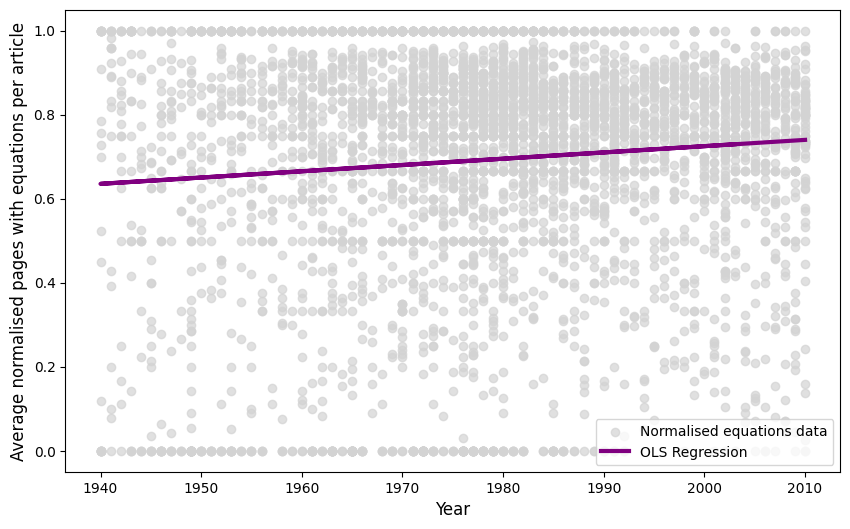

Intercept: 0.6354331687306785
Slope: 0.0014951661573763895


In [383]:
# Independent and dependent variables
ecta_article_data['year_adj'] = ecta_article_data['year'] - 1940
X = ecta_article_data['year_adj'].values.reshape(-1, 1)  # Adjusted year as a feature
y = ecta_article_data['normalized_equation_count']

# Linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 3: Generate predictions for plotting
predicted_values = model.predict(X)

# Step 4: Plot the actual data points and regression line on the same graph
plt.figure(figsize=(10, 6))  

# Actual data (normalised)
plt.scatter(ecta_article_data['year'], y, color='lightgrey', alpha=0.7, label='Normalised equations data')

# Line plot for regression line
plt.plot(ecta_article_data['year'], predicted_values, color='purple', linewidth=3, label='OLS Regression')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average normalised pages with equations per article', fontsize=12)
plt.legend(fontsize=10)  
plt.grid(False)  
plt.show()

# Coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")



In [384]:
# Add a constant term (intercept) for statsmodels
X_with_constant = sm.add_constant(ecta_article_data['year_adj'])

# Fit the OLS regression model
ols_model = sm.OLS(ecta_article_data['normalized_equation_count'], X_with_constant).fit()

# Print the summary statistics
print(ols_model.summary())

# Actual values (y) and predicted values (y_hat)
y_actual = ecta_article_data['normalized_equation_count']
y_predicted = ols_model.predict(X_with_constant)  # Predicted values from the OLS model

# Calculate MSE
mse = mean_squared_error(y_actual, y_predicted)

print(f"Mean Squared Error (MSE): {mse}")

                                OLS Regression Results                               
Dep. Variable:     normalized_equation_count   R-squared:                       0.009
Model:                                   OLS   Adj. R-squared:                  0.009
Method:                        Least Squares   F-statistic:                     38.93
Date:                       Thu, 05 Dec 2024   Prob (F-statistic):           4.82e-10
Time:                               13:57:07   Log-Likelihood:                -424.07
No. Observations:                       4245   AIC:                             852.1
Df Residuals:                           4243   BIC:                             864.8
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

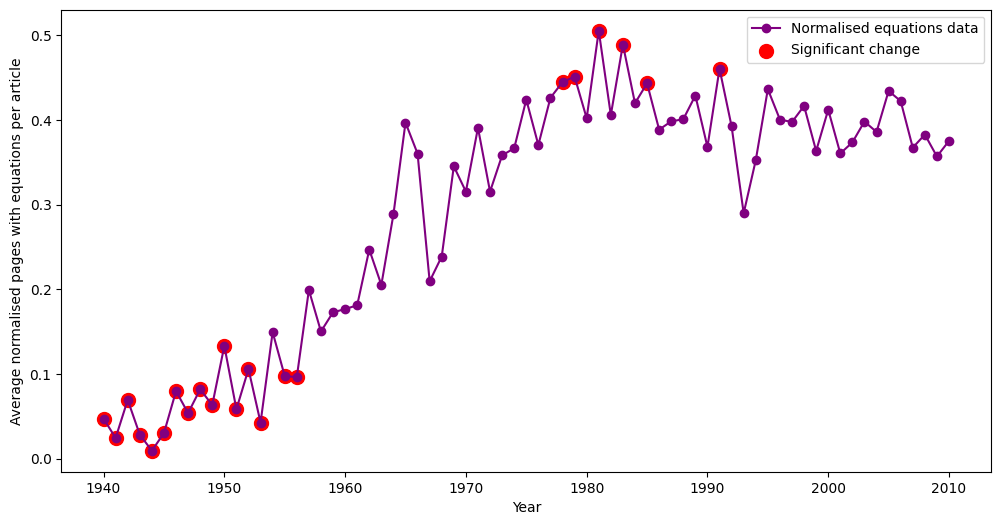

In [385]:
# JPE
jpe_article_data = jpe.groupby('id').agg(
    total_pages=('page', 'size'),
    pages_with_equations=('equations', 'sum')
)
jpe_article_data['normalized_equation_count'] = jpe_article_data['pages_with_equations'] / jpe_article_data['total_pages']
jpe_article_data = jpe_article_data.merge(jpe[['id', 'year']].drop_duplicates(), on='id')
jpe_yearly = jpe_article_data.groupby('year').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)
jpe_yearly['z_score'] = zscore(jpe_yearly['avg_normalized_equations'])
significant_years_jpe = jpe_yearly[jpe_yearly['z_score'].abs() > threshold]

plt.figure(figsize=(12, 6))
plt.plot(jpe_yearly.index, jpe_yearly['avg_normalized_equations'], marker='o', color='purple', label='Normalised equations data')
plt.scatter(significant_years_jpe.index, significant_years_jpe['avg_normalized_equations'], color='red', label='Significant change', s=100)
plt.xlabel('Year')
plt.ylabel('Average normalised pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()


In [386]:
# Average proportion of pages with equations per article z-scores
# Step 1: Create a decade column if it’s not already in your data
jpe_article_data['decade'] = (jpe_article_data['year'] // 10) * 10

# Step 2: Calculate the average normalized equation count per decade
jpe_decade_data = jpe_article_data.groupby('decade').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)

# Step 3: Calculate the z-scores for the average normalized equation count per decade
jpe_decade_data['z_score'] = zscore(jpe_decade_data['avg_normalized_equations'])

# Step 4: Display the table with decade, avg_normalized_equations, and z_score
print(jpe_decade_data)

        avg_normalized_equations   z_score
decade                                    
1940                    0.051963 -1.892985
1950                    0.124079 -1.342596
1960                    0.265738 -0.261443
1970                    0.378261  0.597342
1980                    0.426960  0.969016
1990                    0.387370  0.666857
2000                    0.390303  0.689244
2010                    0.375277  0.574566


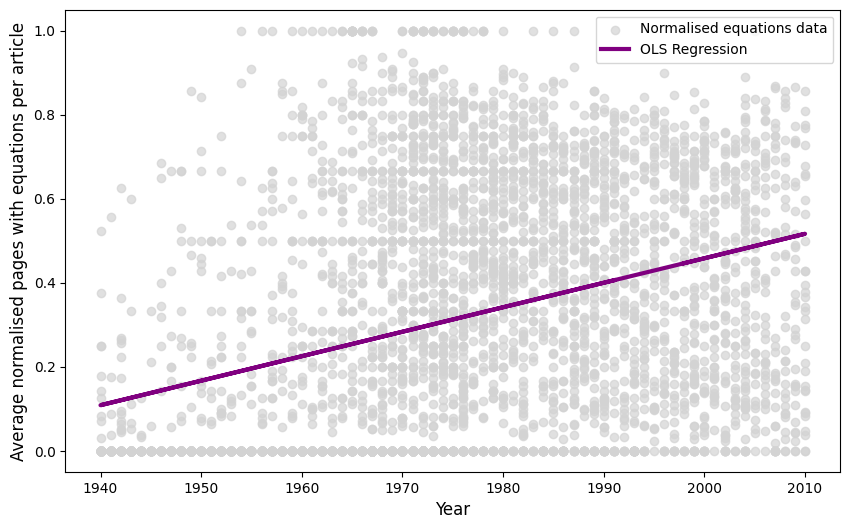

Intercept: 0.10839813044281468
Slope: 0.005830117428486762


In [387]:
# Independent and dependent variables
jpe_article_data['year_adj'] = jpe_article_data['year'] - 1940
X = jpe_article_data['year_adj'].values.reshape(-1, 1)  # Adjusted year as a feature
y = jpe_article_data['normalized_equation_count']

# Linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 3: Generate predictions for plotting
predicted_values = model.predict(X)

# Step 4: Plot the actual data points and regression line on the same graph
plt.figure(figsize=(10, 6))  

# Actual data (normalised)
plt.scatter(jpe_article_data['year'], y, color='lightgrey', alpha=0.7, label='Normalised equations data')

# Line plot for regression line
plt.plot(jpe_article_data['year'], predicted_values, color='purple', linewidth=3, label='OLS Regression')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average normalised pages with equations per article', fontsize=12)
plt.legend(fontsize=10)  
plt.grid(False)  
plt.show()

# Coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")


In [388]:
# Add a constant term (intercept) for statsmodels
X_with_constant = sm.add_constant(jpe_article_data['year_adj'])

# Fit the OLS regression model
ols_model = sm.OLS(jpe_article_data['normalized_equation_count'], X_with_constant).fit()

# Print the summary statistics
print(ols_model.summary())

# Actual values (y) and predicted values (y_hat)
y_actual = jpe_article_data['normalized_equation_count']
y_predicted = ols_model.predict(X_with_constant)  # Predicted values from the OLS model

# Calculate MSE
mse = mean_squared_error(y_actual, y_predicted)

print(f"Mean Squared Error (MSE): {mse}")

                                OLS Regression Results                               
Dep. Variable:     normalized_equation_count   R-squared:                       0.119
Model:                                   OLS   Adj. R-squared:                  0.118
Method:                        Least Squares   F-statistic:                     554.2
Date:                       Thu, 05 Dec 2024   Prob (F-statistic):          4.38e-115
Time:                               13:57:07   Log-Likelihood:                -551.80
No. Observations:                       4122   AIC:                             1108.
Df Residuals:                           4120   BIC:                             1120.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

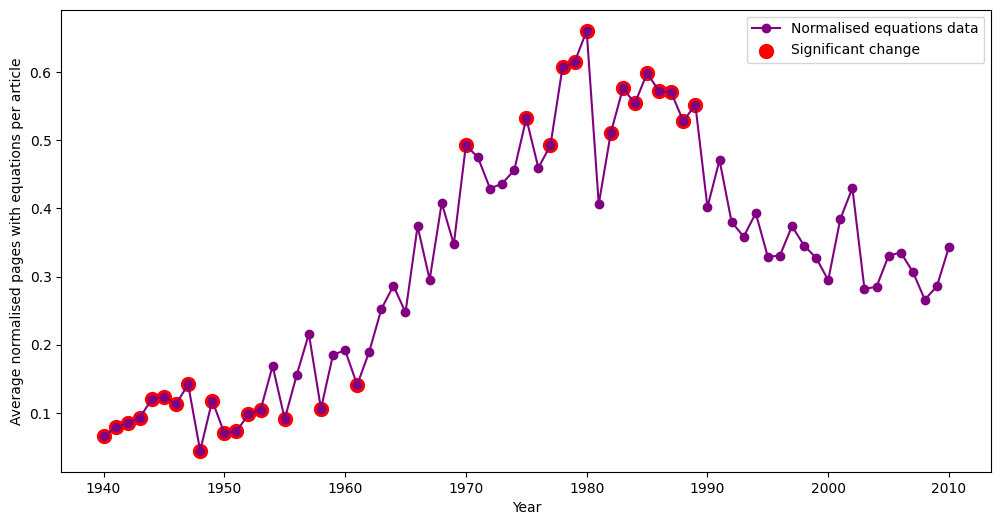

In [389]:
# QJE
qje_article_data = qje.groupby('id').agg(
    total_pages=('page', 'size'),
    pages_with_equations=('equations', 'sum')
)
qje_article_data['normalized_equation_count'] = qje_article_data['pages_with_equations'] / qje_article_data['total_pages']
qje_article_data = qje_article_data.merge(qje[['id', 'year']].drop_duplicates(), on='id')
qje_yearly = qje_article_data.groupby('year').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)
qje_yearly['z_score'] = zscore(qje_yearly['avg_normalized_equations'])
significant_years_qje = qje_yearly[qje_yearly['z_score'].abs() > threshold]

plt.figure(figsize=(12, 6))
plt.plot(qje_yearly.index, qje_yearly['avg_normalized_equations'], marker='o', color='purple', label='Normalised equations data')
plt.scatter(significant_years_qje.index, significant_years_qje['avg_normalized_equations'], color='red', label='Significant change', s=100)
plt.xlabel('Year')
plt.ylabel('Average normalised pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()



In [390]:
# Average proportion of pages with equations per article z-scores
# Step 1: Create a decade column if it’s not already in your data
qje_article_data['decade'] = (qje_article_data['year'] // 10) * 10

# Step 2: Calculate the average normalized equation count per decade
qje_decade_data = qje_article_data.groupby('decade').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)

# Step 3: Calculate the z-scores for the average normalized equation count per decade
qje_decade_data['z_score'] = zscore(qje_decade_data['avg_normalized_equations'])

# Step 4: Display the table with decade, avg_normalized_equations, and z_score
print(qje_decade_data)

        avg_normalized_equations   z_score
decade                                    
1940                    0.094913 -1.509188
1950                    0.127090 -1.297698
1960                    0.272551 -0.341615
1970                    0.497251  1.135282
1980                    0.565149  1.581560
1990                    0.376073  0.338808
2000                    0.319641 -0.032104
2010                    0.343537  0.124955


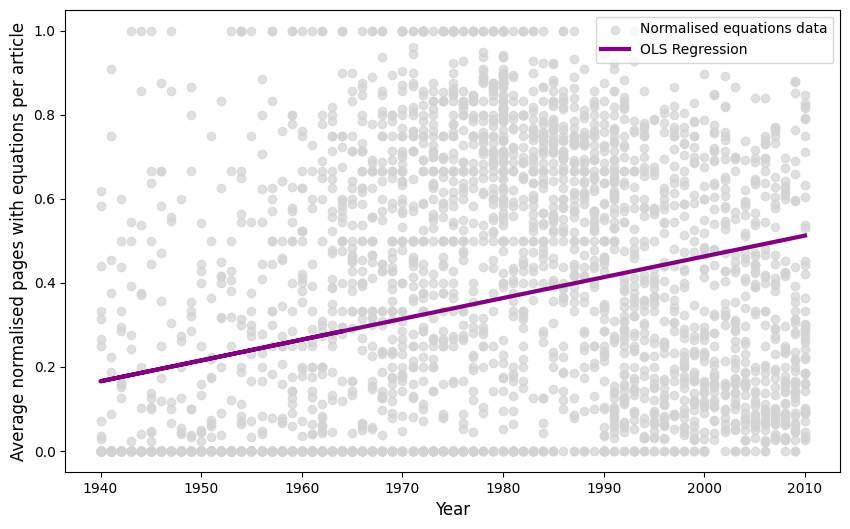

Intercept: 0.16538297424492324
Slope: 0.004955807534252022


In [391]:
# Independent and dependent variables
qje_article_data['year_adj'] = qje_article_data['year'] - 1940
X = qje_article_data['year_adj'].values.reshape(-1, 1)  # Adjusted year as a feature
y = qje_article_data['normalized_equation_count']

# Linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 3: Generate predictions for plotting
predicted_values = model.predict(X)

# Step 4: Plot the actual data points and regression line on the same graph
plt.figure(figsize=(10, 6))  

# Actual data (normalised)
plt.scatter(qje_article_data['year'], y, color='lightgrey', alpha=0.7, label='Normalised equations data')

# Line plot for regression line
plt.plot(qje_article_data['year'], predicted_values, color='purple', linewidth=3, label='OLS Regression')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average normalised pages with equations per article', fontsize=12)
plt.legend(fontsize=10)  
plt.grid(False)  
plt.show()

# Coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")



In [392]:
# Add a constant term (intercept) for statsmodels
X_with_constant = sm.add_constant(qje_article_data['year_adj'])

# Fit the OLS regression model
ols_model = sm.OLS(qje_article_data['normalized_equation_count'], X_with_constant).fit()

# Print the summary statistics
print(ols_model.summary())

# Actual values (y) and predicted values (y_hat)
y_actual = qje_article_data['normalized_equation_count']
y_predicted = ols_model.predict(X_with_constant)  # Predicted values from the OLS model

# Calculate MSE
mse = mean_squared_error(y_actual, y_predicted)

print(f"Mean Squared Error (MSE): {mse}")

                                OLS Regression Results                               
Dep. Variable:     normalized_equation_count   R-squared:                       0.090
Model:                                   OLS   Adj. R-squared:                  0.090
Method:                        Least Squares   F-statistic:                     322.8
Date:                       Thu, 05 Dec 2024   Prob (F-statistic):           6.84e-69
Time:                               13:57:07   Log-Likelihood:                -720.43
No. Observations:                       3256   AIC:                             1445.
Df Residuals:                           3254   BIC:                             1457.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

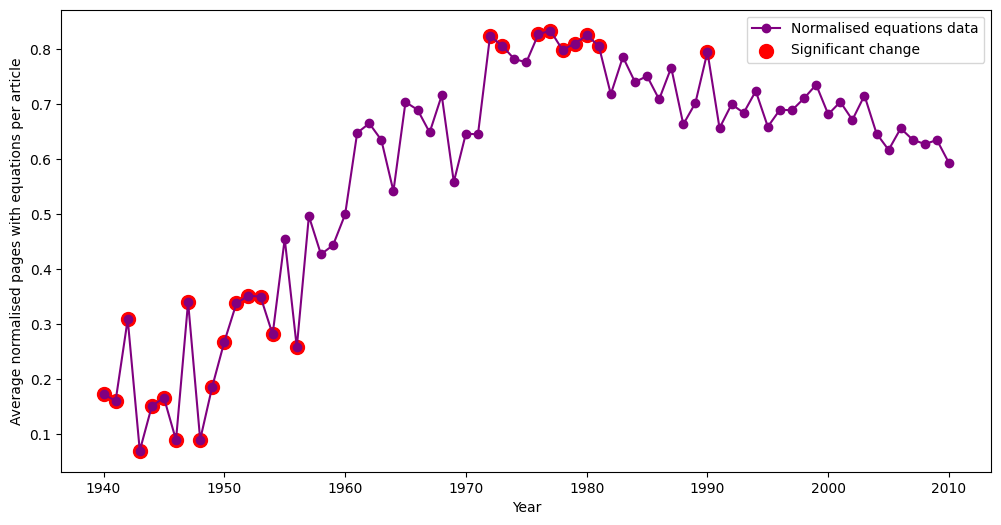

In [393]:
# RES
res_article_data = res.groupby('id').agg(
    total_pages=('page', 'size'),
    pages_with_equations=('equations', 'sum')
)
res_article_data['normalized_equation_count'] = res_article_data['pages_with_equations'] / res_article_data['total_pages']
res_article_data = res_article_data.merge(res[['id', 'year']].drop_duplicates(), on='id')
res_yearly = res_article_data.groupby('year').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)
res_yearly['z_score'] = zscore(res_yearly['avg_normalized_equations'])
significant_years_res = res_yearly[res_yearly['z_score'].abs() > threshold]

plt.figure(figsize=(12, 6))
plt.plot(res_yearly.index, res_yearly['avg_normalized_equations'], marker='o', color='purple', label='Normalised equations data')
plt.scatter(significant_years_res.index, significant_years_res['avg_normalized_equations'], color='red', label='Significant change', s=100)
plt.xlabel('Year')
plt.ylabel('Average normalised pages with equations per article')
plt.legend()
plt.grid(False)
plt.show()


In [394]:
# Average proportion of pages with equations per article z-scores
# Step 1: Create a decade column if it’s not already in your data
res_article_data['decade'] = (res_article_data['year'] // 10) * 10

# Step 2: Calculate the average normalized equation count per decade
res_decade_data = res_article_data.groupby('decade').agg(
    avg_normalized_equations=('normalized_equation_count', 'mean')
)

# Step 3: Calculate the z-scores for the average normalized equation count per decade
res_decade_data['z_score'] = zscore(res_decade_data['avg_normalized_equations'])

# Step 4: Display the table with decade, avg_normalized_equations, and z_score
print(res_decade_data)

        avg_normalized_equations   z_score
decade                                    
1940                    0.180526 -2.106267
1950                    0.377538 -1.076271
1960                    0.628206  0.234245
1970                    0.778090  1.017851
1980                    0.752264  0.882832
1990                    0.703322  0.626958
2000                    0.654899  0.373797
2010                    0.592363  0.046854


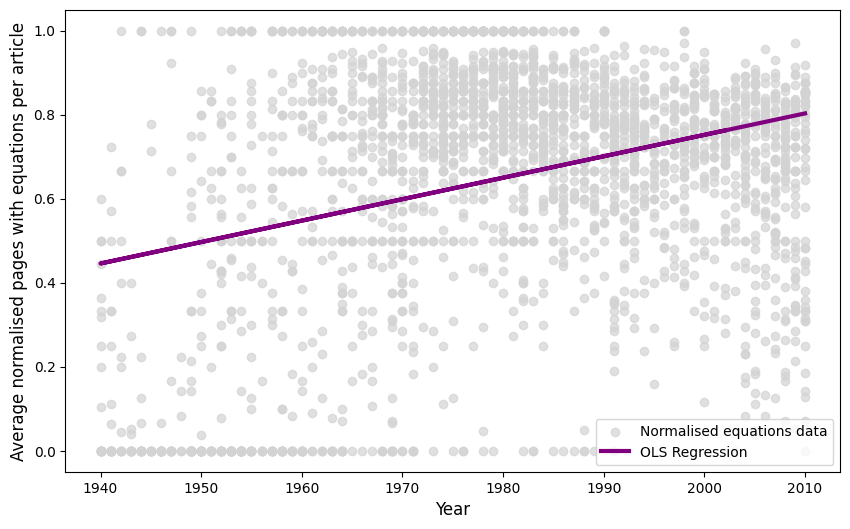

Intercept: 0.4457483352720788
Slope: 0.005105609921831938


In [395]:
# Independent and dependent variables
res_article_data['year_adj'] = res_article_data['year'] - 1940
X = res_article_data['year_adj'].values.reshape(-1, 1)  # Adjusted year as a feature
y = res_article_data['normalized_equation_count']

# Linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 3: Generate predictions for plotting
predicted_values = model.predict(X)

# Step 4: Plot the actual data points and regression line on the same graph
plt.figure(figsize=(10, 6))  

# Actual data (normalised)
plt.scatter(res_article_data['year'], y, color='lightgrey', alpha=0.7, label='Normalised equations data')

# Line plot for regression line
plt.plot(res_article_data['year'], predicted_values, color='purple', linewidth=3, label='OLS Regression')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average normalised pages with equations per article', fontsize=12)
plt.legend(fontsize=10)  
plt.grid(False)  
plt.show()

# Coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")


In [396]:
# Add a constant term (intercept) for statsmodels
X_with_constant = sm.add_constant(res_article_data['year_adj'])

# Fit the OLS regression model
ols_model = sm.OLS(res_article_data['normalized_equation_count'], X_with_constant).fit()

# Print the summary statistics
print(ols_model.summary())

# Actual values (y) and predicted values (y_hat)
y_actual = res_article_data['normalized_equation_count']
y_predicted = ols_model.predict(X_with_constant)  # Predicted values from the OLS model

# Calculate MSE
mse = mean_squared_error(y_actual, y_predicted)

print(f"Mean Squared Error (MSE): {mse}")

                                OLS Regression Results                               
Dep. Variable:     normalized_equation_count   R-squared:                       0.102
Model:                                   OLS   Adj. R-squared:                  0.102
Method:                        Least Squares   F-statistic:                     301.7
Date:                       Thu, 05 Dec 2024   Prob (F-statistic):           4.45e-64
Time:                               13:57:07   Log-Likelihood:                -285.25
No. Observations:                       2651   AIC:                             574.5
Df Residuals:                           2649   BIC:                             586.3
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46814/1896050367.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size), random_state=100))
/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46814/1896050367.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), sample_size), random_state=100))
/var/folders

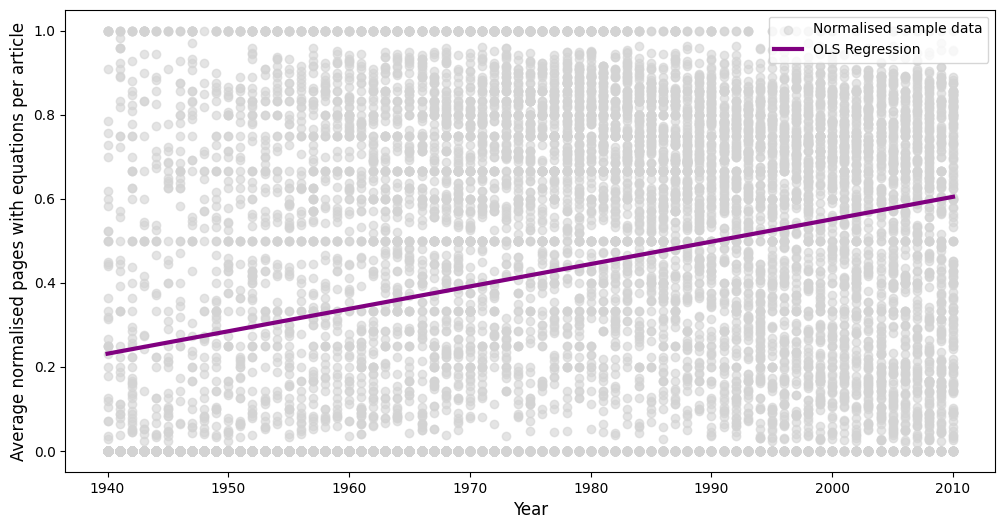

Intercept: 0.23107237840994657
Slope: 0.005335484766938631


In [397]:
# Combined regression
sample_size_per_year = 35
start_year, end_year = 1940, 2010

# Function to sample data from a single journal
def sample_journal_data(journal_data, sample_size, start_year, end_year):
    return (journal_data[journal_data['year'].between(start_year, end_year)]
            .groupby('year')
            .apply(lambda x: x.sample(min(len(x), sample_size), random_state=100))  
            .reset_index(drop=True))

# Apply sampling to each journal
aer_sample = sample_journal_data(article_data, sample_size_per_year, start_year, end_year)
ecta_sample = sample_journal_data(ecta_article_data, sample_size_per_year, start_year, end_year)
jpe_sample = sample_journal_data(jpe_article_data, sample_size_per_year, start_year, end_year)
qje_sample = sample_journal_data(qje_article_data, sample_size_per_year, start_year, end_year)
res_sample = sample_journal_data(res_article_data, sample_size_per_year, start_year, end_year)

# Combine all samples into a single dataset
combined_data = pd.concat([aer_sample, ecta_sample, jpe_sample, qje_sample, res_sample])

# Adjust year so 1940 corresponds to 0
combined_data['year_adj'] = combined_data['year'] - 1940

# Independent (X) and dependent (y) variables
X = combined_data['year_adj'].values.reshape(-1, 1)
y = combined_data['normalized_equation_count']

model = LinearRegression()
model.fit(X, y)
year_range = np.arange(start_year, end_year + 1) - 1940  
predicted_values = model.predict(year_range.reshape(-1, 1))

# Plot actual data and regression line
plt.figure(figsize=(12, 6))

# Scatter plot of actual data points
plt.scatter(combined_data['year'], combined_data['normalized_equation_count'], 
            color='lightgrey', alpha=0.6, label='Normalised sample data')

# Line plot for regression line
plt.plot(year_range + 1940, predicted_values, color='purple', linewidth=3, label='OLS Regression')

# Customize plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average normalised pages with equations per article', fontsize=12)
plt.legend(fontsize=10)
plt.grid(False)
plt.show()

# Print regression coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")


In [398]:
# Independent (X) and dependent (y) variables
X = combined_data['year_adj'].values.reshape(-1, 1)
y = combined_data['normalized_equation_count']

# Add a constant term for the intercept in the model
X = sm.add_constant(X)  

# Fit the OLS regression model
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())

# Predict values using the OLS model
y_pred_ols = ols_model.predict(X)

# Calculate residuals (observed - predicted values)
residuals = y - y_pred_ols

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred_ols)

# Print results
print(f"MSE: {mse:.6f}")

                                OLS Regression Results                               
Dep. Variable:     normalized_equation_count   R-squared:                       0.094
Model:                                   OLS   Adj. R-squared:                  0.094
Method:                        Least Squares   F-statistic:                     1225.
Date:                       Thu, 05 Dec 2024   Prob (F-statistic):          2.04e-255
Time:                               13:57:08   Log-Likelihood:                -3744.2
No. Observations:                      11814   AIC:                             7492.
Df Residuals:                          11812   BIC:                             7507.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

Optimization terminated successfully.
         Current function value: 0.566381
         Iterations 6


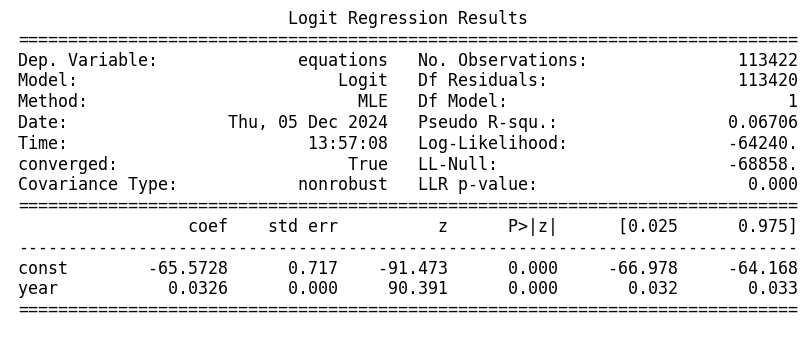

In [399]:
# Binary Logistic Regression
# AER
# Add a constant term (intercept) to the model
X = sm.add_constant(aer['year'])  # Independent variable: year
y = aer['equations']              # Dependent variable: equations (0 or 1)

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

# Get the summary as a string
summary_str = logit_model.summary().as_text()

# Set up the figure and plot the text
fig, ax = plt.subplots(figsize=(10, 1))  # Adjust size as needed
ax.text(0.01, 0.5, summary_str, fontsize=12, fontname="monospace", wrap=True)  # Wrap the text to fit
ax.axis("off")  # Hide axes

# Save the figure
plt.savefig('logit_regression_results.png', bbox_inches='tight')
plt.show()


Optimization terminated successfully.
         Current function value: 0.521057
         Iterations 6


/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46814/271674450.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


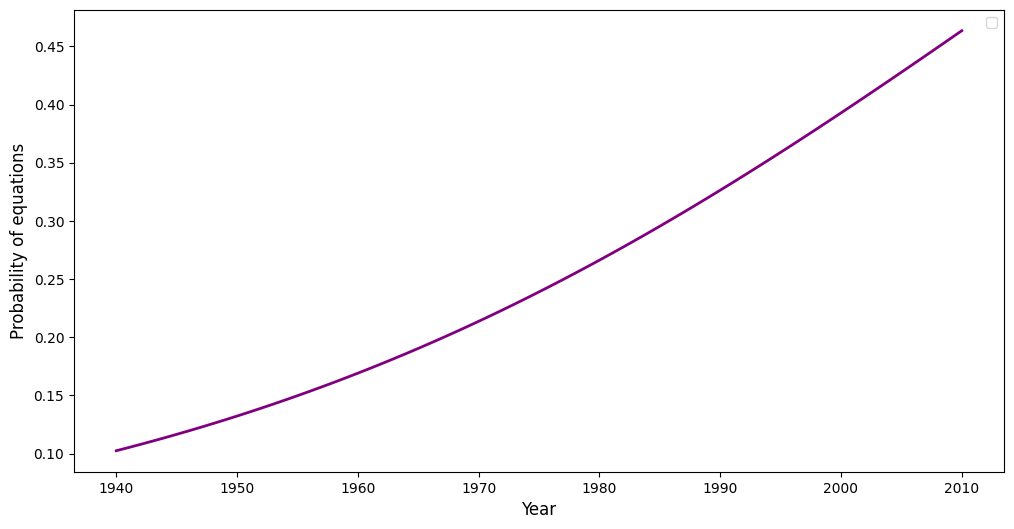

Intercept (β₀): -2.1702052327638954
Slope (β₁): 0.028909788374261537


In [400]:
# AER
# Step 1: Adjust year so that X = 0 corresponds to 1940
article_data['year_adj'] = article_data['year'] - 1940

# Step 2: Fit the logistic regression model using normalized data
# Independent variable: adjusted year
X = sm.add_constant(article_data['year_adj'])  

# Dependent variable: normalized_equation_count
y = article_data['normalized_equation_count']

logit_model = sm.Logit(y, X).fit()

# Step 3: Generate predicted probabilities for a range of years
year_range = np.arange(article_data['year'].min(), article_data['year'].max() + 1)
year_range_adj = year_range - 1940  # Adjusted year range
X_pred = sm.add_constant(year_range_adj)
predicted_probs = logit_model.predict(X_pred)

# Step 4: Plot the actual normalized data and the predicted trend
plt.figure(figsize=(12, 6))

# Line plot of predicted probabilities
plt.plot(year_range, predicted_probs, color='purple', linewidth=2)

# Customize the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Probability of equations', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

# Step 5: Extract coefficients
intercept = logit_model.params['const']
slope = logit_model.params['year_adj']

# Print the intercept and slope
print(f"Intercept (β₀): {intercept}")
print(f"Slope (β₁): {slope}")


In [401]:
# Chi-squared statistic
chi_squared = logit_model.llr  # Model log-likelihood ratio
print(f"Chi-squared: {chi_squared}")

# P-value for the chi-squared test
p_value = logit_model.llr_pvalue
print(f"P-value: {p_value}")

# Pseudo R-squared
pseudo_r2 = logit_model.prsquared
print(f"Pseudo R-squared: {pseudo_r2}")



Chi-squared: -302.6677249476834
P-value: 1.0
Pseudo R-squared: -0.026771846503654162


In [402]:
odds_ratios = np.exp(logit_model.params)
print(odds_ratios)


const       0.114154
year_adj    1.029332
dtype: float64


Optimization terminated successfully.
         Current function value: 0.565577
         Iterations 5


/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46814/3679003011.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


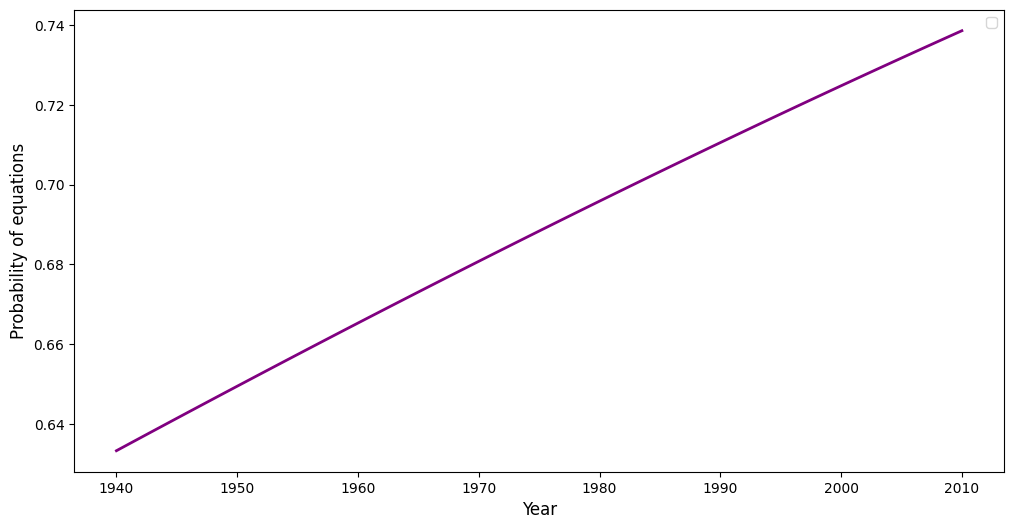

Intercept (β₀): 0.546139673586431
Slope (β₁): 0.007034746522365519


In [403]:
# ECTA
# Step 1: Adjust year so that X = 0 corresponds to 1940
ecta_article_data['year_adj'] = ecta_article_data['year'] - 1940

# Step 2: Fit the logistic regression model using normalized data
# Independent variable: adjusted year
X = sm.add_constant(ecta_article_data['year_adj'])  

# Dependent variable: normalized_equation_count
y = ecta_article_data['normalized_equation_count']

logit_model = sm.Logit(y, X).fit()

# Step 3: Generate predicted probabilities for a range of years
year_range = np.arange(ecta_article_data['year'].min(), ecta_article_data['year'].max() + 1)
year_range_adj = year_range - 1940  # Adjusted year range
X_pred = sm.add_constant(year_range_adj)
predicted_probs = logit_model.predict(X_pred)

# Step 4: Plot the actual normalized data and the predicted trend
plt.figure(figsize=(12, 6))

# Line plot of predicted probabilities
plt.plot(year_range, predicted_probs, color='purple', linewidth=2)

# Customize the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Probability of equations', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

# Step 5: Extract coefficients
intercept = logit_model.params['const']
slope = logit_model.params['year_adj']

# Print the intercept and slope
print(f"Intercept (β₀): {intercept}")
print(f"Slope (β₁): {slope}")



In [404]:
# Calculate the chi-squared statistic
chi2_stat = 2 * (logit_model.llf - logit_model.llnull)
df_diff = logit_model.df_model  # Degrees of freedom for the full model

# Calculate the p-value for the chi-square test
p_value = chi2.sf(chi2_stat, df_diff)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value for Likelihood Ratio Test: {p_value}")

Chi-squared statistic: -542.2264158381286
P-value for Likelihood Ratio Test: 1.0


In [405]:
odds_ratios = np.exp(logit_model.params)
print(odds_ratios)

const       1.726575
year_adj    1.007060
dtype: float64


/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46814/943986520.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Optimization terminated successfully.
         Current function value: 0.565954
         Iterations 5


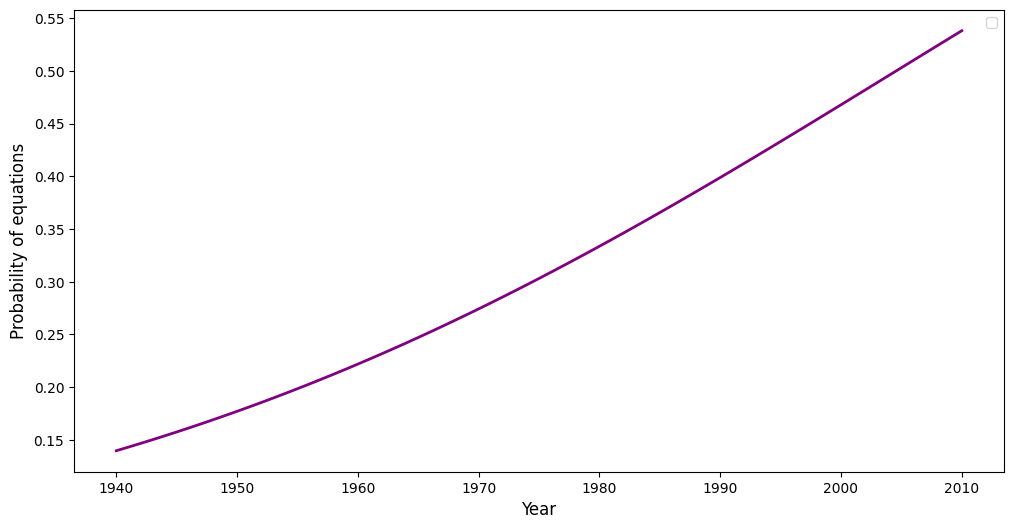

Intercept (β₀): -1.8177412820733663
Slope (β₁): 0.02814874723059411


In [406]:
# JPE
# Step 1: Adjust year so that X = 0 corresponds to 1940
jpe_article_data['year_adj'] = jpe_article_data['year'] - 1940

# Step 2: Fit the logistic regression model using normalized data
# Independent variable: adjusted year
X = sm.add_constant(jpe_article_data['year_adj'])  

# Dependent variable: normalized_equation_count
y = jpe_article_data['normalized_equation_count']

logit_model = sm.Logit(y, X).fit()

# Step 3: Generate predicted probabilities for a range of years
year_range = np.arange(jpe_article_data['year'].min(), jpe_article_data['year'].max() + 1)
year_range_adj = year_range - 1940  # Adjusted year range
X_pred = sm.add_constant(year_range_adj)
predicted_probs = logit_model.predict(X_pred)

# Step 4: Plot the actual normalized data and the predicted trend
plt.figure(figsize=(12, 6))

# Line plot of predicted probabilities
plt.plot(year_range, predicted_probs, color='purple', linewidth=2)

# Customize the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Probability of equations', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

# Step 5: Extract coefficients
intercept = logit_model.params['const']
slope = logit_model.params['year_adj']

# Print the intercept and slope
print(f"Intercept (β₀): {intercept}")
print(f"Slope (β₁): {slope}")


In [407]:
# Calculate the chi-squared statistic
chi2_stat = 2 * (logit_model.llf - logit_model.llnull)
df_diff = logit_model.df_model  # Degrees of freedom for the full model

# Calculate the p-value for the chi-square test
p_value = chi2.sf(chi2_stat, df_diff)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value for Likelihood Ratio Test: {p_value}")

Chi-squared statistic: -196.6398308054313
P-value for Likelihood Ratio Test: 1.0


In [408]:
odds_ratios = np.exp(logit_model.params)
print(odds_ratios)


const       0.162392
year_adj    1.028549
dtype: float64


Optimization terminated successfully.
         Current function value: 0.597929
         Iterations 5


/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46814/3468930613.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


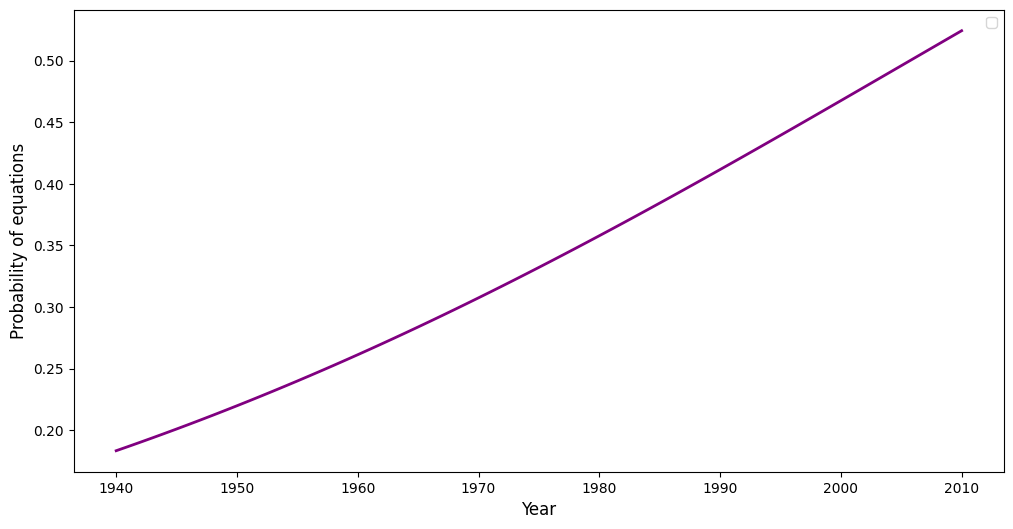

Intercept (β₀): -1.4944131939313594
Slope (β₁): 0.02273502159170642


In [409]:
# QJE
# Step 1: Adjust year so that X = 0 corresponds to 1940
qje_article_data['year_adj'] = qje_article_data['year'] - 1940

# Step 2: Fit the logistic regression model using normalized data
# Independent variable: adjusted year
X = sm.add_constant(qje_article_data['year_adj'])  

# Dependent variable: normalized_equation_count
y = qje_article_data['normalized_equation_count']

logit_model = sm.Logit(y, X).fit()

# Step 3: Generate predicted probabilities for a range of years
year_range = np.arange(qje_article_data['year'].min(), qje_article_data['year'].max() + 1)
year_range_adj = year_range - 1940  # Adjusted year range
X_pred = sm.add_constant(year_range_adj)
predicted_probs = logit_model.predict(X_pred)

# Step 4: Plot the actual normalized data and the predicted trend
plt.figure(figsize=(12, 6))

# Line plot of predicted probabilities
plt.plot(year_range, predicted_probs, color='purple', linewidth=2)

# Customize the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Probability of equations', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

# Step 5: Extract coefficients
intercept = logit_model.params['const']
slope = logit_model.params['year_adj']

# Print the intercept and slope
print(f"Intercept (β₀): {intercept}")
print(f"Slope (β₁): {slope}")


In [410]:
# Calculate the chi-squared statistic
chi2_stat = 2 * (logit_model.llf - logit_model.llnull)
df_diff = logit_model.df_model  # Degrees of freedom for the full model

# Calculate the p-value for the chi-square test
p_value = chi2.sf(chi2_stat, df_diff)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value for Likelihood Ratio Test: {p_value}")

Chi-squared statistic: -57.710445231050016
P-value for Likelihood Ratio Test: 1.0


In [411]:
odds_ratios = np.exp(logit_model.params)
print(odds_ratios)

const       0.224380
year_adj    1.022995
dtype: float64


Optimization terminated successfully.
         Current function value: 0.579688
         Iterations 5


/var/folders/1z/gvfs_wzn1ds72j8v4cnfy29c0000gn/T/ipykernel_46814/800134699.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


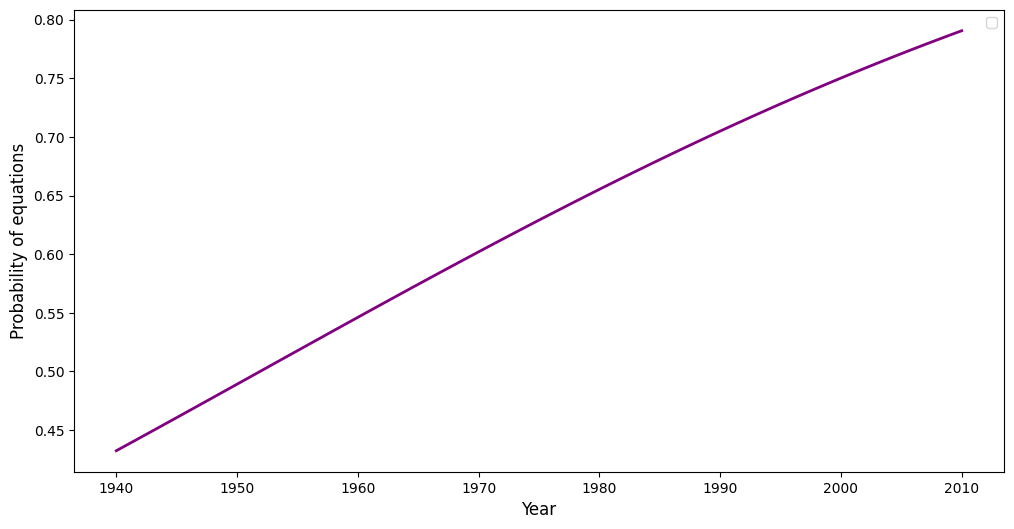

Intercept (β₀): -0.2721899371671952
Slope (β₁): 0.022868676375431992


In [412]:
# RES
# Step 1: Adjust year so that X = 0 corresponds to 1940
res_article_data['year_adj'] = res_article_data['year'] - 1940

# Step 2: Fit the logistic regression model using normalized data
# Independent variable: adjusted year
X = sm.add_constant(res_article_data['year_adj'])  

# Dependent variable: normalized_equation_count
y = res_article_data['normalized_equation_count']

logit_model = sm.Logit(y, X).fit()

# Step 3: Generate predicted probabilities for a range of years
year_range = np.arange(res_article_data['year'].min(), res_article_data['year'].max() + 1)
year_range_adj = year_range - 1940  # Adjusted year range
X_pred = sm.add_constant(year_range_adj)
predicted_probs = logit_model.predict(X_pred)

# Step 4: Plot the actual normalized data and the predicted trend
plt.figure(figsize=(12, 6))

# Line plot of predicted probabilities
plt.plot(year_range, predicted_probs, color='purple', linewidth=2)

# Customize the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Probability of equations', fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

# Step 5: Extract coefficients
intercept = logit_model.params['const']
slope = logit_model.params['year_adj']

# Print the intercept and slope
print(f"Intercept (β₀): {intercept}")
print(f"Slope (β₁): {slope}")


In [413]:
# Calculate the chi-squared statistic
chi2_stat = 2 * (logit_model.llf - logit_model.llnull)
df_diff = logit_model.df_model  # Degrees of freedom for the full model

# Calculate the p-value for the chi-square test
p_value = chi2.sf(chi2_stat, df_diff)

print(f"Chi-squared statistic: {chi2_stat}")
print(f"P-value for Likelihood Ratio Test: {p_value}")

Chi-squared statistic: -31.829272276495885
P-value for Likelihood Ratio Test: 1.0


In [414]:
odds_ratios = np.exp(logit_model.params)
print(odds_ratios)

const       0.761710
year_adj    1.023132
dtype: float64


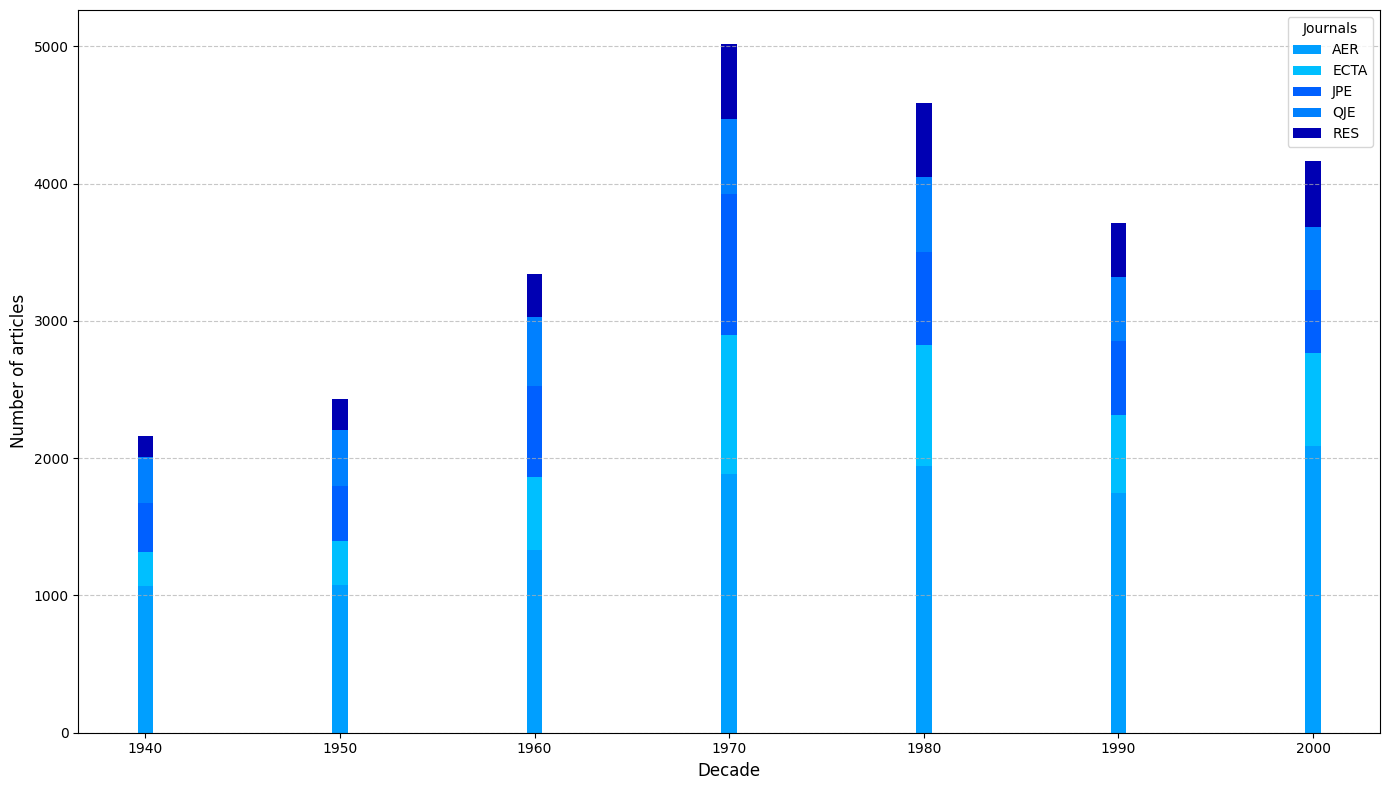

In [415]:
# Combine 2000 and 2010 decades into a single "2000s" category
decade_table.loc[2000] = decade_table.loc[2000] + decade_table.loc[2010]

# Drop the 2010 row as it's now merged
decade_table.drop(2010, inplace=True)

# Reset index for consistency
decade_table.reset_index(inplace=True)
decade_table.rename(columns={'index': 'decade'}, inplace=True)

# Prepare data for stacked bar plot
decades = decade_table['decade']
aer = decade_table['AER']
ecta = decade_table['ECTA']
jpe = decade_table['JPE']
qje = decade_table['QJE']
res = decade_table['RES']

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))
bar_width = 1 
ax.bar(decades, aer, label='AER', color='#009fff')
ax.bar(decades, ecta, bottom=aer, label='ECTA', color='#00bfff')
ax.bar(decades, jpe, bottom=aer+ecta, label='JPE', color='#0060ff')
ax.bar(decades, qje, bottom=aer+ecta+jpe, label='QJE', color='#0080ff')
ax.bar(decades, res, bottom=aer+ecta+jpe+qje, label='RES', color='#0000b3')

# Customize plot
#ax.set_title('Number of Articles per Decade (Stacked Bar Graph)', fontsize=14)
ax.set_xlabel('Decade', fontsize=12)
ax.set_ylabel('Number of articles', fontsize=12)
ax.legend(title='Journals')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_xticks(decades)
ax.set_xticklabels(decades)
plt.tight_layout()

# Show plot
plt.show()